<a id="t1."></a>
# 1. Import data and python packages

In [57]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [58]:
# Define paths
train_directory = Path("../Beef1/Meat/train")
test_directory = Path("../Beef1/Meat/test")
valid_directory = Path("../Beef1/Meat/valid")

In [59]:
# Set the desired sample size
sample_size = 1033

# Set the desired width and height for resizing images
width = 224
height = 224

In [60]:
files = ['Fresh', 'Melted']

def load_images(directory, files, sample_size):
    data = {}
    for f in files:
        data[f] = []

    for col in files:
        dir_path = directory / col
        image_files = [file for file in os.listdir(dir_path) if file.endswith('.jpg')]
        
        # Use all images if fewer than sample_size
        if len(image_files) < sample_size:
            selected_files = image_files
        else:
            selected_files = np.random.choice(image_files, sample_size, replace=False)
        
        for file in selected_files:
            data[col].append(os.path.join(dir_path, file))

    image_data = []
    image_target = []

    for title in files:
        for file in data[title]:
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, (width, height))
            image_data.append(img_resized)
            image_target.append(title)
    
    return np.array(image_data), np.array(image_target)

# Load and preprocess training data
image_train_data, image_train_target = load_images(train_directory, files, sample_size)
image_test_data, image_test_target = load_images(test_directory, files, sample_size)
image_valid_data, image_valid_target = load_images(valid_directory, files, sample_size)

In [61]:
# Verify loaded data
print(f"Training data shape: {image_train_data.shape}")
print(f"Training labels shape: {image_train_target.shape}")
print(f"Test data shape: {image_test_data.shape}")
print(f"Test labels shape: {image_test_target.shape}")
print(f"Validation data shape: {image_valid_data.shape}")
print(f"Validation labels shape: {image_valid_target.shape}")

Training data shape: (2066, 224, 224, 3)
Training labels shape: (2066,)
Test data shape: (464, 224, 224, 3)
Test labels shape: (464,)
Validation data shape: (464, 224, 224, 3)
Validation labels shape: (464,)


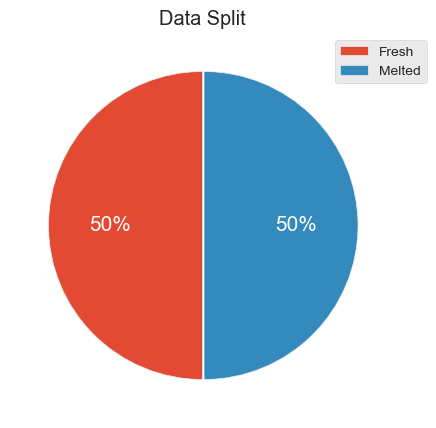

In [62]:
# Plot the data distribution
sizes = [len(image_train_target[image_train_target == 'Fresh']), len(image_train_target[image_train_target == 'Melted'])]

plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color':"w", "fontsize":15}, startangle=90, explode=(0, .01))
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

<a id="t2."></a>
# 2. Data visualization

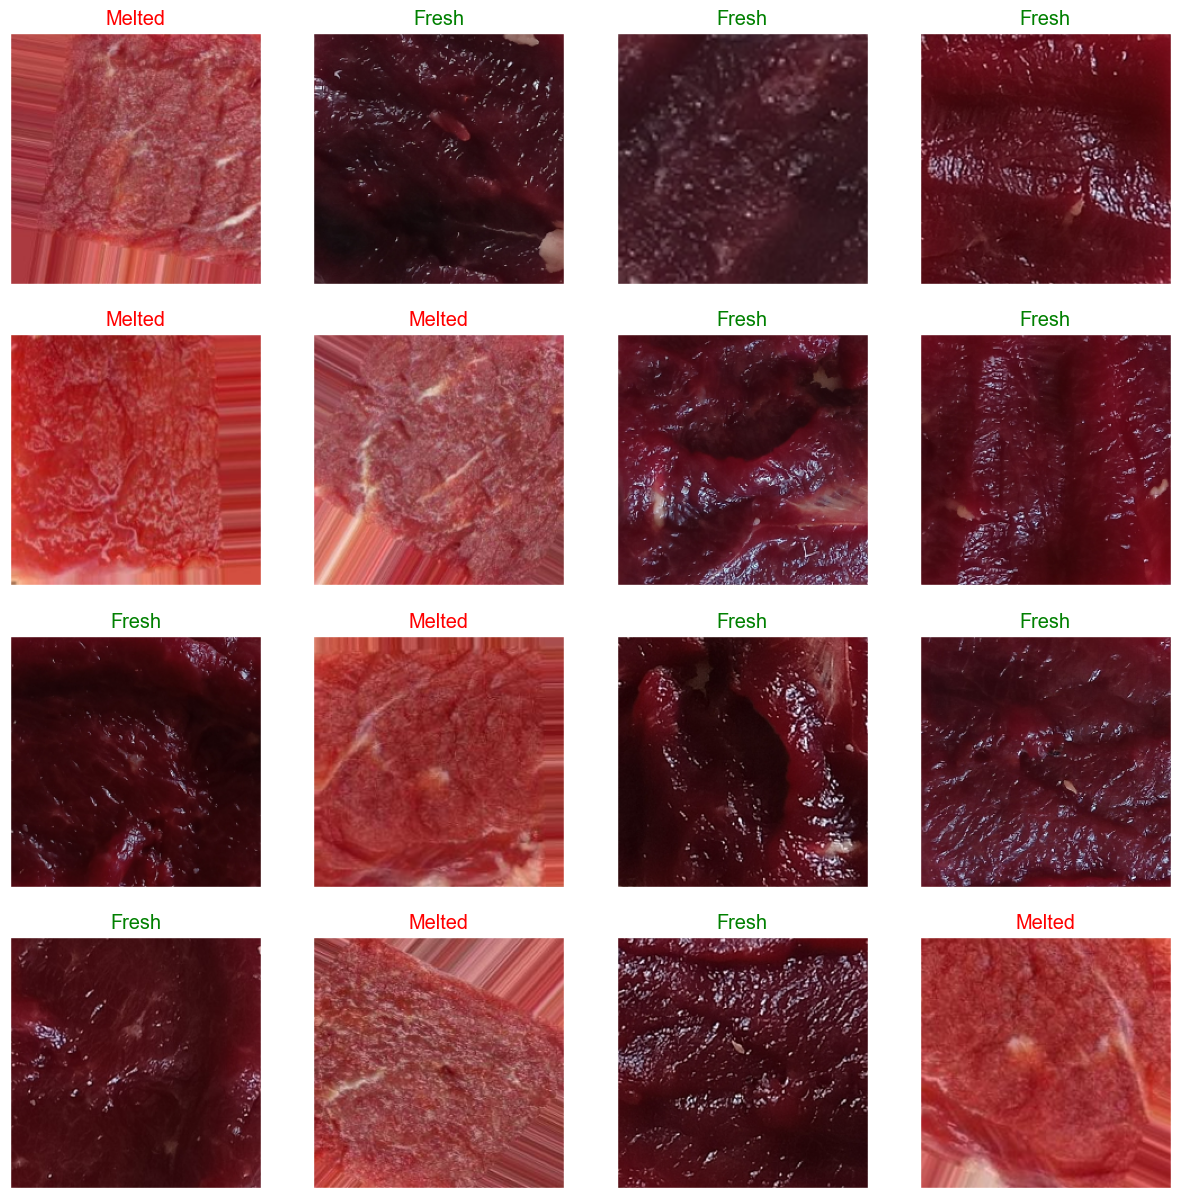

In [63]:
# Define size_train to be the length of image_train_data
size_train = len(image_train_data)

plt.figure(figsize=(15, 15))
for i in range(1, 17):
    fig = np.random.randint(size_train)
    plt.subplot(4, 4, i)
    plt.imshow(image_train_data[fig])
    if image_train_target[fig] == 'Fresh':
        c = 'green'
    else:
        c = 'red'
    plt.title(image_train_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

<a id="t3."></a>
# 3. Classification (CNN)

In [64]:
from sklearn.preprocessing import LabelEncoder

In [65]:
labels = LabelEncoder()
labels.fit(image_train_target)

LabelEncoder()

In [66]:
# Normalize the images
X_train = image_train_data / 255.0
X_test = image_test_data / 255.0
X_valid = image_valid_data / 255.0

# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(image_train_target)
y_test = label_encoder.transform(image_test_target)
y_valid = label_encoder.transform(image_valid_target)

In [67]:


# train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.15, random_state=123)

# #Bagi data menjadi set pelatihan (70%) dan set sementara (30%)
# train_images, temp_images, train_labels, temp_labels = train_test_split(X, y, test_size=0.30, random_state=123)
# 
# #Bagi set sementara menjadi set validasi (15%) dan set pengujian (15%)
# validation_images, test_images, validation_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.50, random_state=123)

# Memeriksa ukuran set
print(f"Train set size: {y_train.shape[0]}")
print(f"Validation set size: {y_valid.shape[0]}")
print(f"Test set size: {y_test.shape[0]}")

Train set size: 2066
Validation set size: 464
Test set size: 464


In [68]:
from tensorflow.keras.utils import to_categorical
    
# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)

In [69]:
# train_images, train_labels = X , y
# test_images , test_labels = tX, ty

In [70]:
# Membuat model Sequential
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2)
])

In [71]:
model.compile(optimizer='RMSprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 111, 111, 16)      64        
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      4640      
                                                      

In [73]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Call_Back = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model-2.h5', monitor='val_loss', save_best_only=True)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.99 and logs.get('val_accuracy') > 0.99):
            print("\nReached or Exceed 99.0% accuracy so cancelling training!")
            self.model.stop_training = True
            
callback = myCallback()

In [74]:
# from sklearn.preprocessing import LabelEncoder

# # Convert train_labels and test_labels to integers using LabelEncoder
# label_encoder = LabelEncoder()
# train_labels_encoded = label_encoder.fit_transform(train_labels)
# test_labels_encoded = label_encoder.transform(test_labels)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    verbose=1,
    callbacks=[Call_Back, callback]
)


Epoch 1/20
65/65 [==============================] - 22s 321ms/step - loss: 0.9806 - accuracy: 0.9690 - val_loss: 0.4461 - val_accuracy: 0.9181
Epoch 2/20
65/65 [==============================] - 18s 281ms/step - loss: 0.0217 - accuracy: 0.9956 - val_loss: 0.4413 - val_accuracy: 0.5388
Epoch 3/20
65/65 [==============================] - 18s 281ms/step - loss: 0.0284 - accuracy: 0.9942 - val_loss: 0.1892 - val_accuracy: 0.9224
Epoch 4/20
65/65 [==============================] - 18s 279ms/step - loss: 0.0264 - accuracy: 0.9976 - val_loss: 0.1200 - val_accuracy: 0.9353
Epoch 5/20
65/65 [==============================] - 18s 281ms/step - loss: 2.8773e-04 - accuracy: 1.0000 - val_loss: 0.1238 - val_accuracy: 0.9332
Epoch 6/20
65/65 [==============================] - 18s 281ms/step - loss: 0.0113 - accuracy: 0.9981 - val_loss: 0.1158 - val_accuracy: 0.9353
Epoch 7/20
65/65 [==============================] - 18s 285ms/step - loss: 1.7647e-04 - accuracy: 1.0000 - val_loss: 0.2995 - val_accuracy

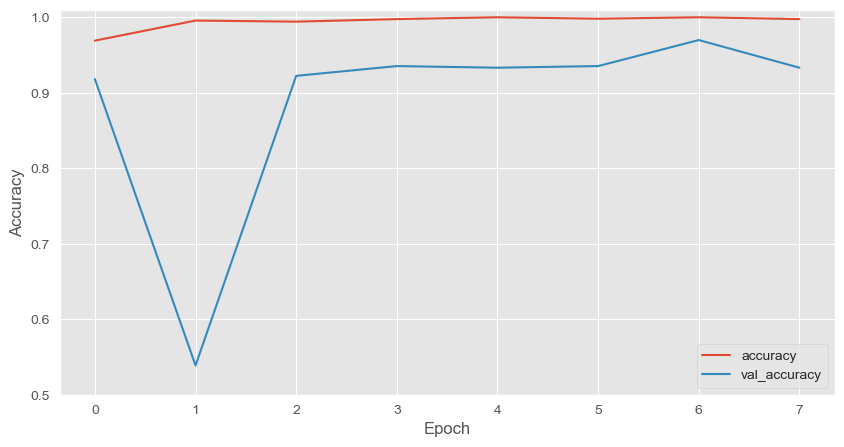

In [75]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

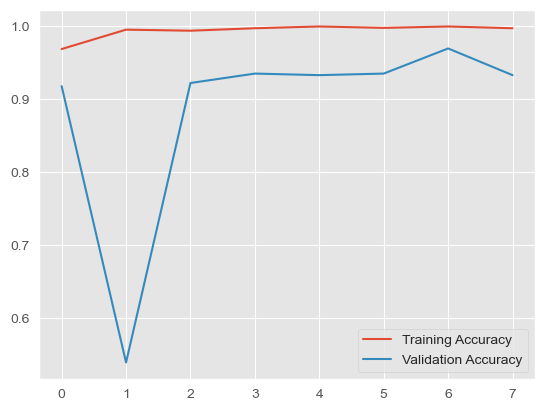

In [76]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [77]:
result=model.evaluate(X_test, y_test)

15/15 [==============================] - 1s 81ms/step - loss: 2.8196 - accuracy: 0.9203


In [78]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 2.8195953369140625
accuracy : 0.920258641242981


<a id="t4."></a>
# 4. Prediction

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

15/15 [==============================] - 1s 82ms/step


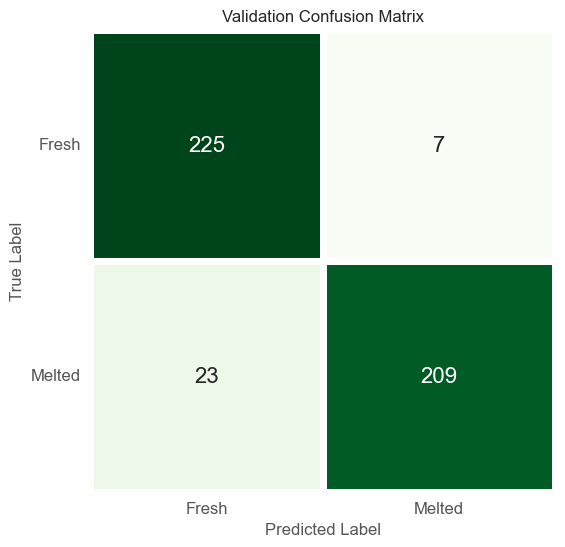

In [80]:
# Prediksi pada data validasi
y_val_pred = model.predict(X_valid)

# Definisi fungsi untuk mengkonversi prediksi ke kelas
def toClass(pred):
    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index
    return class_

# Membuat confusion matrix untuk data validasi
cm_val = confusion_matrix(y_valid, toClass(y_val_pred))

df_val = pd.DataFrame(columns=["Fresh", "Melted"], index=["Fresh", "Melted"], data=cm_val)

f_val, ax_val = plt.subplots(figsize=(6, 6))
sns.heatmap(df_val, annot=True, cmap="Greens", fmt='.0f', ax=ax_val, linewidths=5, cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size=12)
plt.yticks(size=12, rotation=0)
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix", size=12)
plt.show()

15/15 [==============================] - 1s 81ms/step


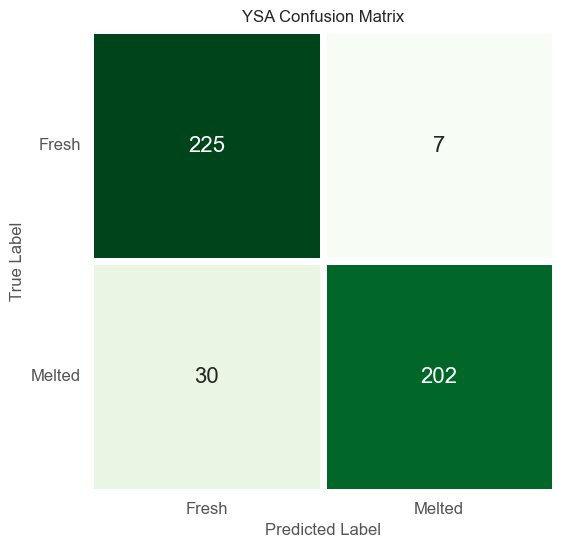

In [81]:
y_pred = model.predict(X_test)

def toClass(pred):
    
    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index
        
    return class_

cm = confusion_matrix(y_test,toClass(y_pred))

df1 = pd.DataFrame(columns=["Fresh","Melted"], index= ["Fresh","Melted"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("YSA Confusion Matrix", size = 12)
plt.show()

In [82]:
from sklearn.metrics import classification_report

# Prediksi kelas untuk data uji
y_pred_class = toClass(y_pred)

# Buat classification report
report = classification_report(y_test, y_pred_class, target_names=files)

# Tampilkan classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       Fresh       0.88      0.97      0.92       232
      Melted       0.97      0.87      0.92       232

    accuracy                           0.92       464
   macro avg       0.92      0.92      0.92       464
weighted avg       0.92      0.92      0.92       464


In [83]:
def prediction(image):
    global width, height, model
    
    img = cv2.resize(image, (width, height))
    img = img / 255.0
    pred = model.predict(np.array([img])).argmax()
    
    return files[pred]

1/1 [==============================] - 0s 26ms/step


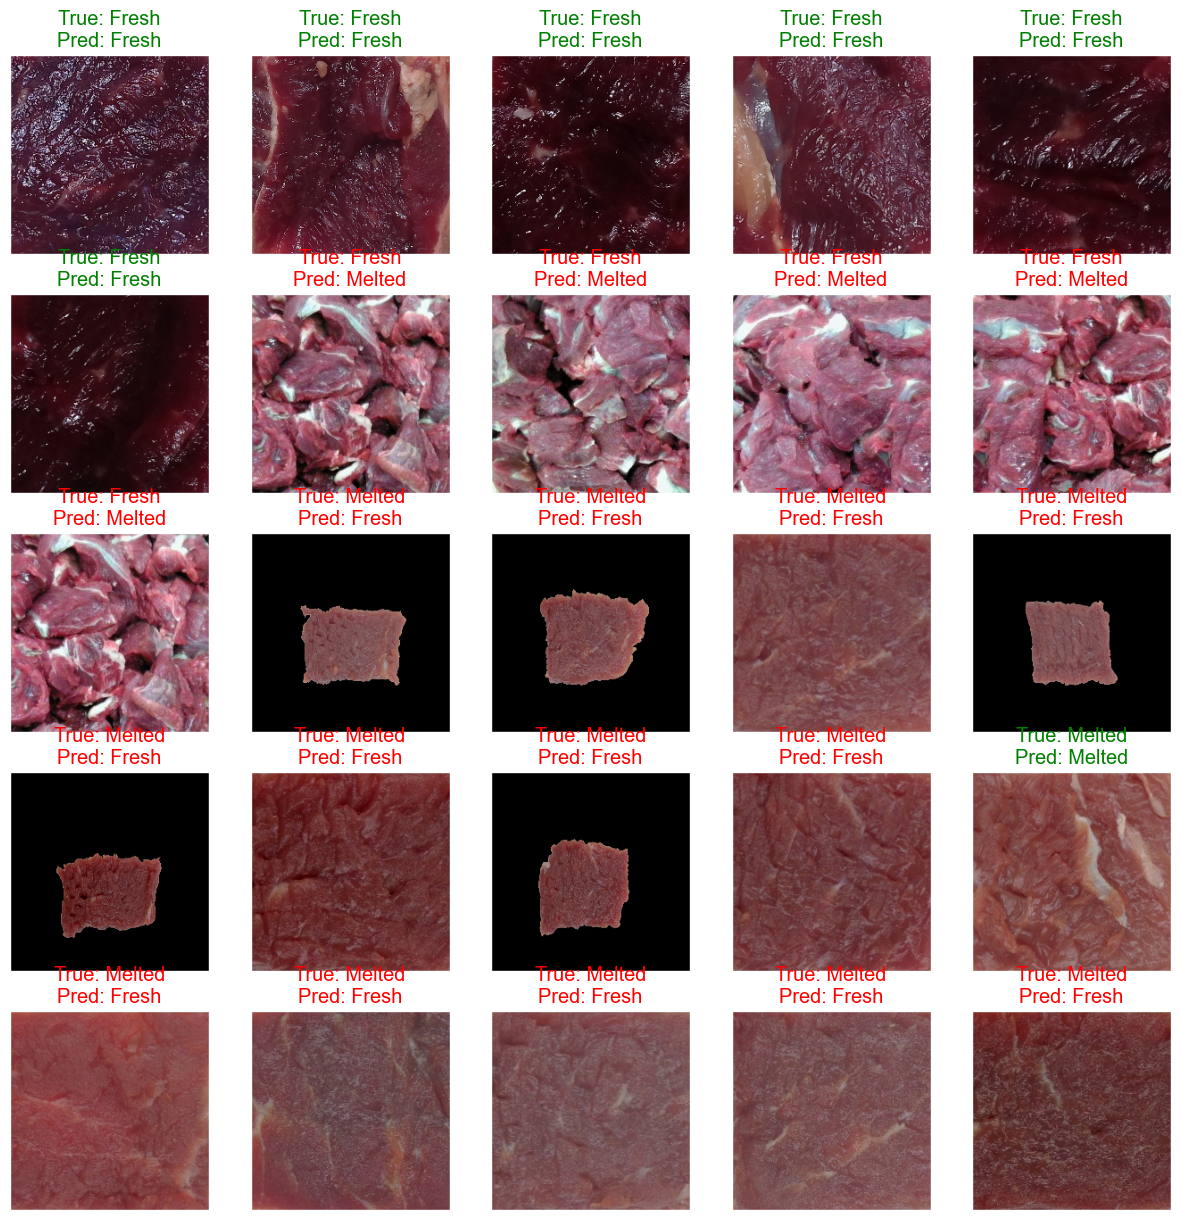

In [84]:

start_index = 220  # Indeks awal untuk menampilkan gambar
num_images = 25  # Jumlah gambar yang ingin ditampilkan
size_test = len(image_test_data)

plt.figure(figsize=(15,15))
for i in range(1, num_images + 1):
    fig = start_index + i
    plt.subplot(5, 5, i)
    plt.imshow(image_test_data[fig])
    actual_label = image_test_target[fig]
    predicted_label = prediction(image_test_data[fig])
    if actual_label == predicted_label:
        c = 'green'
    else:
        c = 'red'
    plt.title(f"True: {actual_label}\nPred: {predicted_label}", color=c)
    plt.xticks([]), plt.yticks([])
plt.show()